In [1]:
import torch
import torch.nn as nn
import numpy as np

import torchvision
import pathlib


In [2]:


batch_size_train = 1024
batch_size_test = 10

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x : x*255)
])
# Define the loader for training data.
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('.', train=True, download=True,transform=transform),
  batch_size=batch_size_train, shuffle=True)

# Define the loader for testing data.
test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('.', train=False, download=True, transform=transform),
  batch_size=batch_size_test, shuffle=False)

first_b = next(iter(test_loader))

print(np.min(first_b[0].numpy()))
print(np.max(first_b[0].numpy()))
print(np.mean(first_b[0].numpy()))



0.0
255.0
29.54222


# Loss Construction

$$
\log p(x) \geq \log p(x|z) - \text{KL}[q(z|x) \| p(x)]
$$

So this is a lower bound for the log-likelihood, but most loss functions are minimized ("minimal loss" instead of "maximal gain", from the intuition of risk). So

$$
\mathcal{L} = -\log p(x) = \underbrace{-\log p(x|z)}_{\text{MSE}} + \underbrace{\text{KL}[q(z|x) \| p(x)]}_{\text{Regularizer}}
$$

The MSE term is already implemented in TF/PyTorch etc, so let's focus on the second one. From ~~stackoverflow~~ trusted sources, KL divergence between Gaussians q and p are given by

$$
\text{KL}[q\| p] = 0.5 (\log \frac{\det\Sigma_p}{\det\Sigma_q} - k + \text{tr}\Sigma_p^{-1}\Sigma_q + (\mu_2 - \mu_1)^T\Sigma_p^{-1} (\mu_2 - \mu_1))
$$

where $k$ is the dimension of the space. We know that $p(x)$ is the standard normal $\mathcal{N}(0,I)$. So for us, we have:

$$
\text{KL}[q\| \mathcal{N}(0,I) ] = 0.5 (\log \frac{1}{\det\Sigma_q} - k + \text{tr}\Sigma_q + \mu_q^T \mu_q)
$$

Use log rules to flip the fraction in the first term
$$
\text{KL}[q\| \mathcal{N}(0,I) ] = 0.5 (-\log \det\Sigma_q - k + \text{tr}\Sigma_q + \mu_q^T \mu_q)
$$

Then use $\log \det$ identity to turn a product into a sum
$$
\text{KL}[q\| \mathcal{N}(0,I) ] = 0.5 (-\text{tr}\log \Sigma_q - k + \text{tr}\Sigma_q + \mu_q^T \mu_q)
$$


In [3]:
def KL_div_N01(z_mu, z_log_sigma_sq):
    term_1 = z_log_sigma_sq.sum(axis=1) # this is trace log Sigma q
    term_2 = z_log_sigma_sq.exp().sum(axis=1) # this is trace Sigma q
    term_3 = (z_mu*z_mu).sum(axis=1) # this is mu_q squared and summed
    return 0.5*(-term_1 + term_2 + term_3 - z_mu.shape[1]).mean() #k is a constant, so we're going to ignore that


# Building an auto-encoder in Pytorch

This section constructs the "actual" network, composed of an encoder and a decoder. Both here are Linear to ReLU repeated layers, and have the same number of hidden units. This doesn't generally have to be true, you could instead use different architectures for the encoder and decoder. It also ties the precursor functions to $z$, $f_\mu$ and $f_\sigma$, together by having them be two sections of the same encoder function. This need not be true either.

In [4]:


##
## fully connected
##
class VAE( nn.Module ):
    def __init__(self, n_input, n_output, n_z, n_layers, layer_size):
        super(VAE, self).__init__()

        self.enc = nn.ModuleList()
        self.dec = nn.ModuleList()
        self.n_z = n_z

        for i in range(n_layers+1):
            if i == 0: #first layers
                self.enc.append(nn.Linear(n_input, layer_size))
                self.dec.append(nn.Linear(n_z, layer_size))
                self.enc.append(nn.ReLU())
                self.dec.append(nn.ReLU())
            elif i == n_layers: #last layers
                self.enc.append(nn.Linear(layer_size, 2*n_z)) # we need this for enc's mu and sigma
                self.dec.append(nn.Linear(layer_size, n_output))
            else:
                self.enc.append(nn.Linear(layer_size, layer_size))
                self.dec.append(nn.Linear(layer_size, layer_size))
                self.enc.append(nn.ReLU())
                self.dec.append(nn.ReLU())

        self.enc = nn.Sequential(*self.enc)
        self.dec = nn.Sequential(*self.dec)
  
  
    def enc_to_mean_lss(self,x):
        enc_output = self.enc(x)
        mean = enc_output[...,:self.n_z]
        log_sigma_sq = enc_output[...,self.n_z:]
        return mean, log_sigma_sq

    def forward(self, x):
        mean, log_sigma_sq = self.enc_to_mean_lss(x)

        sigma = log_sigma_sq.exp().sqrt()
        z = mean + torch.randn_like(mean)*sigma
        output = self.dec(z)

        return output
  
    def forward_train(self, x):

        mean, log_sigma_sq = self.enc_to_mean_lss(x)
        z = mean + torch.randn_like(mean) * (log_sigma_sq.exp().sqrt())
        output = self.dec(z)

        return output, mean, log_sigma_sq
  
    def encode_mean(self,x):
        mean, log_sigma_sq = self.enc_to_mean_lss(x)
        return mean

    def encode(self,x):
        mean, log_sigma_sq = self.enc_to_mean_lss(x)
        sigma = self.enc_log_sigma_sq.exp().sqrt()
        return mean + torch.randn_like(mean)*sigma

    def decode(self,z):
        return self.dec(z)




# Training

This section constructs a neural network and then trains it on the training data for (default) 100 epochs using the Adam optimizer. Feel free to play around with the parameters.

On its default settings it takes about 10 minutes to train on CPU on a 4 core (8-thread) machine. However, the reconstructions still don't look _that_ good...so if you'd like, you can change the parameters to see if you can do better. 

Occasionally this training will `nan` out; restart this whole block (which restarts from a fresh random initialization of the network).

In [6]:
## network params
input_size = 28**2
n_z = 2
n_layers = 3
layer_size = 512

saved_params_path="saved_params"
pathlib.Path(f"./{saved_params_path}/").mkdir(parents=True, exist_ok=True)

## training params
n_epochs = 100

vae_instance = VAE(n_input=input_size, n_output=input_size, n_z=n_z, n_layers=n_layers, layer_size=layer_size)

# Define the loss function.
mse_loss_func = torch.nn.MSELoss()
kl_loss_func = KL_div_N01

# Define the optimizer.
optimizer = torch.optim.Adam(vae_instance.parameters(), lr=3e-4)

print(vae_instance)
for epoch in range(n_epochs):

    running_loss = 0.0
    running_kl_loss = 0.0
    running_mse_loss = 0.0
    running_n = 0
    
    for i, data in enumerate(train_loader, 0):

        inputs, labels = data
        
        images_in = inputs.view(inputs.shape[0], -1).clone().detach()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        x_hat, mean, log_sigma_sq  = vae_instance.forward_train(images_in)
        
        mse_loss = mse_loss_func(x_hat, images_in)
        kl_div_loss = kl_loss_func(mean, log_sigma_sq)
        loss = mse_loss + kl_div_loss
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_kl_loss += kl_div_loss.item()
        running_mse_loss += mse_loss.item()
        running_n += inputs.shape[0]

    print(
        f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / running_n:.6f}',
        f'KL loss: {running_kl_loss / running_n:.6f}',
        f'MSE loss: {running_mse_loss / running_n:.6f}')
    running_loss = 0.0
    running_kl_loss = 0.0
    running_mse_loss = 0.0
    running_n = 0
    
    torch.save(vae_instance.state_dict(), f'{saved_params_path}/{epoch}.pth')

# Save the trained model
torch.save(vae_instance.state_dict(), 'final_model.pth')
# Save the optimization states. This is helpful for continual training.
torch.save(optimizer.state_dict(), 'optimizer.pth')

print('Finished Training')

VAE(
  (enc): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=4, bias=True)
  )
  (dec): Sequential(
    (0): Linear(in_features=2, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=784, bias=True)
  )
)
[1,    59] loss: 5.143526 KL loss: 0.149456 MSE loss: 4.994070
[2,    59] loss: 4.080969 KL loss: 0.019787 MSE loss: 4.061181
[3,    59] loss: 4.072796 KL loss: 0.013402 MSE loss: 4.059395
[4,    59] loss: 4.065608 KL loss: 0.011255 MSE loss: 4.054353
[5,    59] loss: 3.875770 KL loss: 0.021905 MSE loss: 3.853865
[6,    59] loss: 3.635184 KL loss: 0.020

# Evaluation and Plotting



In [7]:
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

def plot_reconstructed(decode_function, ranges=((-2,2),(-2,2)), n_sample_points=10, image_dim=28):
    
    img = np.zeros((n_sample_points*image_dim, n_sample_points*image_dim))
    
    for i, y in enumerate(np.linspace(*ranges[0], n_sample_points)):
        for j, x in enumerate(np.linspace(*ranges[1], n_sample_points)):
            z = torch.Tensor([[x, y]])
            
            x_hat = decode_function(z)
            x_hat = x_hat.reshape(28, 28).detach().numpy()
            img[
                (n_sample_points-1-i)*image_dim:(n_sample_points-1-i+1)*image_dim,
                j*image_dim:(j+1)*image_dim] = x_hat

    plt.imshow(img, extent=[*ranges[0], *ranges[1]])

def imshow(img):
    npimg = img.numpy()
    npimg = np.clip(npimg/255.,0,1) #we need to clip here to avoid bad image values
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


In [8]:
vae_instance.load_state_dict(torch.load(f"{saved_params_path}/99.pth"))
output,mean_z,log_var_z = vae_instance.forward_train(images_in)
output_1,mean_z_1,log_var_z_1 = vae_instance.forward_train(output)
print(mean_z - mean_z_1)
print(mean_z)
print(mean_z_1)

tensor([[-0.0267,  0.2700],
        [ 0.1974,  0.0578],
        [ 0.5104, -0.0210],
        ...,
        [-0.0577,  0.1167],
        [ 0.0140,  0.0478],
        [ 0.2921,  0.0380]], grad_fn=<SubBackward0>)
tensor([[-2.9603, -2.4633],
        [-3.0403,  1.8763],
        [ 5.8543, -1.8742],
        ...,
        [-3.5346,  3.0181],
        [-3.7610,  3.6426],
        [ 2.5342, -4.3033]], grad_fn=<SliceBackward0>)
tensor([[-2.9336, -2.7333],
        [-3.2377,  1.8185],
        [ 5.3439, -1.8532],
        ...,
        [-3.4769,  2.9014],
        [-3.7750,  3.5948],
        [ 2.2422, -4.3413]], grad_fn=<SliceBackward0>)


9
torch.Size([10, 1, 28, 28])


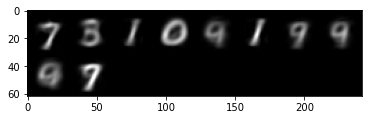

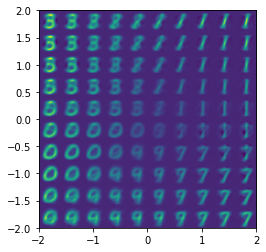

19
torch.Size([10, 1, 28, 28])


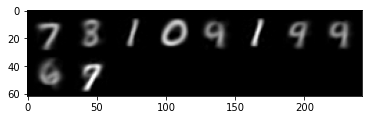

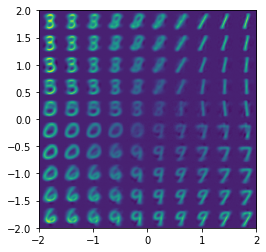

29
torch.Size([10, 1, 28, 28])


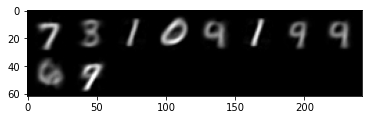

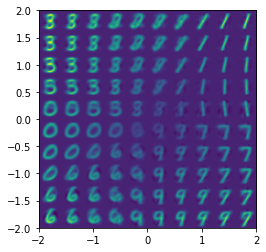

39
torch.Size([10, 1, 28, 28])


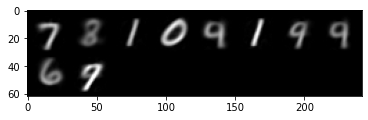

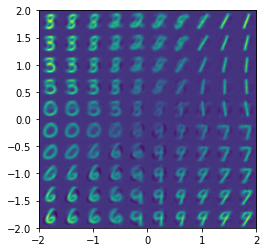

49
torch.Size([10, 1, 28, 28])


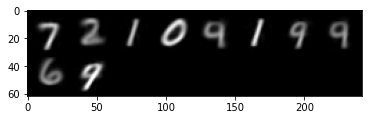

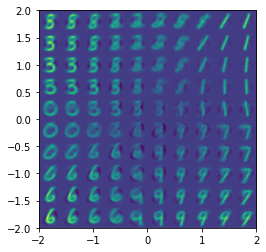

59
torch.Size([10, 1, 28, 28])


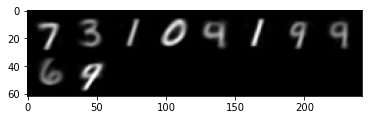

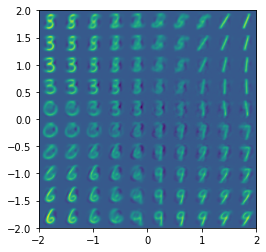

69
torch.Size([10, 1, 28, 28])


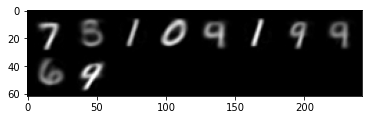

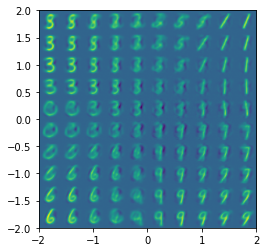

79
torch.Size([10, 1, 28, 28])


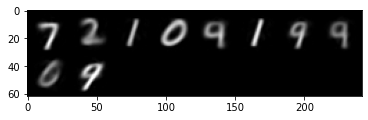

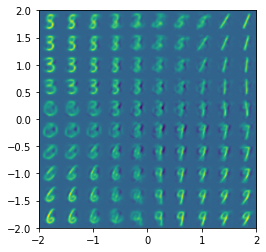

89
torch.Size([10, 1, 28, 28])


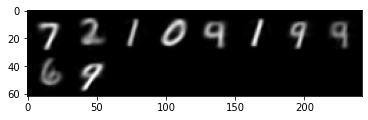

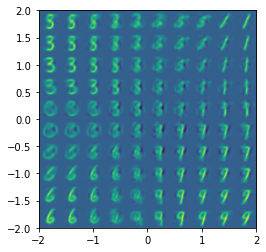

99
torch.Size([10, 1, 28, 28])


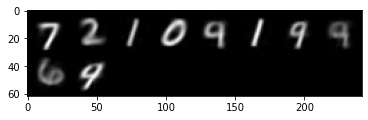

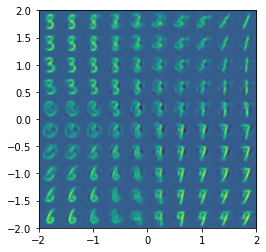

In [9]:

vae_instance.eval()

batch = next(iter(test_loader))
images, labels = batch

for epoch in range(9,100,10):
    print(epoch)
    vae_instance.load_state_dict(torch.load(f"{saved_params_path}/{epoch}.pth"))

    images_in = images.view(-1,28**2)

    output,mean_z,log_var_z = vae_instance.forward_train(images_in)

    output = output.view(10,1,28,28).clone().detach()
    print(output.shape)
    image_outputs = torchvision.utils.make_grid(output)
    
    imshow(image_outputs)
    
    plot_reconstructed(
        vae_instance.decode
    )
    plt.show()

# GIF Code

The very important "impress your advisor/boss" code. Note that `duration` is time-per-frame, and `loop` is actually an inverted flag, so `loop=False` causes the gif to loop.

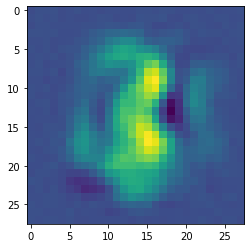

In [10]:
import imageio

def make_z_space_gif(decode_function, n_sample_points = 90):
    import pathlib
    pathlib.Path("./gif_files/").mkdir(parents=True, exist_ok=True)
    
    filenames = []
    for i, t in enumerate(np.linspace(0, 2*np.pi, 90)):
        x = np.sin(t)
        y = np.cos(t)
        
        z = torch.Tensor([[x, y]])
            
        x_hat = decode_function(z)
        x_hat = x_hat.reshape(28, 28).detach().numpy()
        plt.imshow(x_hat)
        plt.savefig(f"gif_files/{i}.png")
        filenames.append(f"gif_files/{i}.png")

    images = []
    with imageio.get_writer("z_space_circle.gif", mode="I", duration=1./30., loop=False) as w:
        for fname in filenames:
            w.append_data(imageio.imread(fname))

make_z_space_gif(
    vae_instance.decode
)